# Perform visual areas identification using Intrinsic Imaging

### Usage

#### 1) Generate the intrinsic imaging data

Experimental protocol reproduced from: 
> [Juavinett et al. "Automated identification of mouse visual areas with intrinsic signal imaging." Nature protocols 12.1 (2017): 32-43.](https://www.nature.com/articles/nprot.2016.158)

Using the idea of [Kalatsky & Stryker, _Neuron_ (2003)](http://doi.org/10.1016/s0896-6273(03)00286-1). See demo at the bottom of the notebook.

Launch the GUI with:

`$ python physion/intrinsic_imaging/gui.py`

#### 2) Compute azimuth and altitude maps with
`$ python physion/intrinsic_imaging/Analysis.py -df DATAFOLDER`

#### 3) Perform area segmentation and visualize the output with:
`$ python physion/intrinsic_imaging/Analysis.py -df DATAFOLDER --segmentation`

#### 4) Other visualization/debug tools

plot single protocol maps (e.e. "up" protocol) with: `$ python physion/intrinsic_imaging/Analysis.py -df DATAFOLDER --plot --protocol up`

### Visualizing output after analysis

In [14]:
# --- load standard modules
import pprint, os, sys
import numpy as np
import matplotlib.pylab as plt
# --- physion modules
sys.path.append(os.path.join(os.path.expanduser('~'), 'work', 'physion'))
import physion
from physion.dataviz.datavyz.datavyz import graph_env_manuscript as ge

patch01AU=3892.25 AS=4575.212306717333 ratio=1.1754672250542317
Only one local minumum was found!!!
patch02AU=1458.5 AS=2106.6329793452564 ratio=1.4443832563217391
Only one local minumum was found!!!
patch03AU=547.25 AS=650.9929677706308 ratio=1.1895714349394806
Only one local minumum was found!!!
patch04AU=702.5 AS=1043.9016020119186 ratio=1.485980928130845
Only one local minumum was found!!!
patch05AU=178.0 AS=208.88114975553 ratio=1.173489605368146
Only one local minumum was found!!!
merge iteration: 1
merging: patch02 & patch03, overlap ratio: 0.0077661032434901784
merge iteration: 2


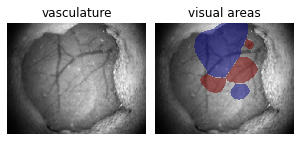

In [12]:
datafolder = os.path.join(os.path.expanduser('~'), 'DATA', '2022_09_13', '15-26-26')
# -- loading data
maps = physion.intrinsic.Analysis.load_maps(datafolder)

# -- recompute areas based on stored parameters
trial_data = physion.intrinsic.Analysis.build_trial_data(maps, with_params=True)
trial = physion.intrinsic.RetinotopicMapping.RetinotopicMappingTrial(**trial_data)
trial.processTrial()

# -- plotting maps
if 'fluorescence' in maps:
    fig, AX = ge.figure(axes=(3,1), figsize=(1.5,3), wspace=0.1)
    AX[2].imshow(maps['fluorescence']**.3, cmap='gray', interpolation='nearest')
else:
    fig, AX = ge.figure(axes=(2,1), figsize=(1.5,3), wspace=0.1)
    
AX[0].imshow(maps['vasculature']**.3, cmap='gray', interpolation='nearest')
AX[1].imshow(maps['vasculature']**.3, cmap='gray', interpolation='nearest')
physion.intrinsic.Analysis.add_patches(trial, AX[1])
for ax, title in zip(AX, ['vasculature', 'visual areas', 'fluorescence']):
    ax.set_title(title)
    ax.axis('off')

# Implementation details

In [59]:
# --- load a data folder
datafolder = os.path.join(os.path.expanduser('~'), 'DATA', '2022_09_13', '15-26-26')
maps = np.load(os.path.join(datafolder, 'draft-maps.npy'), allow_pickle=True).item()
params, (t, data) = physion.intrinsic.Analysis.load_raw_data(datafolder,
                                                             'up', run_id=1)

## Look at raw Intrinsic Imaging data

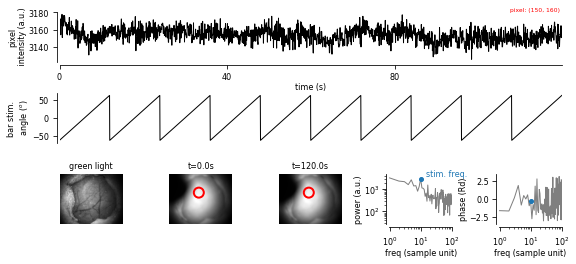

In [63]:
# plot raw data
def show_raw_data(t, data, params, maps,
                  pixel=(200,200)):
    
    fig, AX = ge.figure(axes_extents=[[[5,1]],[[5,1]],[[1,1] for i in range(5)]],
                        wspace=1.2, figsize=(1,1.1))

    AX[0][0].plot(t, data[:,pixel[0], pixel[1]], 'k', lw=1)
    ge.set_plot(AX[0][0], ylabel='pixel\n intensity (a.u.)', xlabel='time (s)',
                xlim=[t[0], t[-1]])
    ge.annotate(AX[0][0], 'pixel: (%i, %i) ' % pixel, (1,1), ha='right', color='r', size='x-small')

    AX[1][0].plot(params['STIM']['up-times'], params['STIM']['up-angle'], 'k', lw=1)
    ge.set_plot(AX[1][0], ['left'], 
                ylabel='bar stim.\n angle ($^o$)',
                xlim=[t[0], t[-1]])

    ge.image(np.rot90(maps['vasculature'], k=1), ax=AX[2][0],
             title='green light')

    AX[2][1].scatter([pixel[0]], [pixel[1]], s=100, color='none', edgecolor='r', lw=2)
    ge.image(np.rot90(data[0,:,:], k=1), ax=AX[2][1],
             title='t=%.1fs' % t[0])

    AX[2][2].scatter([pixel[0]], [pixel[1]], s=100, color='none', edgecolor='r', lw=2)
    ge.image(np.rot90(data[-1,:,:], k=1), ax=AX[2][2],
             title='t=%.1fs' % t[-1])

    spectrum = np.fft.fft(data[:,pixel[0], pixel[1]], axis=0)
    
    power, phase = np.abs(spectrum), np.angle(spectrum)

    AX[2][3].plot(np.arange(1, len(power)), power[1:], color=ge.gray, lw=1)
    AX[2][3].plot([params['Nrepeat']], [power[params['Nrepeat']]], 'o', color=ge.blue, ms=4)
    ge.annotate(AX[2][3], '  stim. freq.', (params['Nrepeat'], power[params['Nrepeat']]), 
                color=ge.blue, xycoords='data', ha='left')

    AX[2][4].plot(np.arange(1, len(power)), phase[1:], color=ge.gray, lw=1)
    AX[2][4].plot([params['Nrepeat']], [phase[params['Nrepeat']]], 'o', color=ge.blue, ms=4)

    ge.set_plot(AX[2][3], xscale='log', yscale='log', 
                xlim=[.99,101], ylim=[power[1:].max()/120.,1.5*power[1:].max()],
                xlabel='freq (sample unit)', ylabel='power (a.u.)')
    ge.set_plot(AX[2][4], xscale='log', 
                xlim=[.99,101], xlabel='freq (sample unit)', ylabel='phase (Rd)')

show_raw_data(t, data, params, maps, pixel=(150,160))

## Compute retinotopic maps

In [61]:
datafolder = os.path.join(os.path.expanduser('~'), 'DATA', '2022_09_13', '15-26-26')
maps = {}
maps = physion.intrinsic.Analysis.compute_retinotopic_maps(datafolder, 'altitude', maps=maps)
maps = physion.intrinsic.Analysis.compute_retinotopic_maps(datafolder, 'azimuth', maps=maps)
np.save(os.path.join(datafolder, 'draft-maps.npy'), maps)

- computing "altitude" retinotopic maps [...] 
-> retinotopic map calculation over ! 
- computing "azimuth" retinotopic maps [...] 
-> retinotopic map calculation over ! 


## Visualizing retinotopic maps

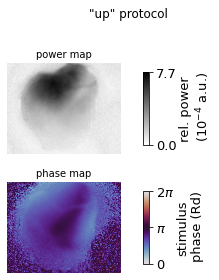

In [64]:
# reloading the above analysis
datafolder = os.path.join(os.path.expanduser('~'), 'DATA', '2022_09_13', '15-26-26')
maps = np.load(os.path.join(datafolder, 'draft-maps.npy'), allow_pickle=True).item()
fig = physion.intrinsic.Analysis.plot_phase_power_maps(maps, 'up') # just one stim: "up"

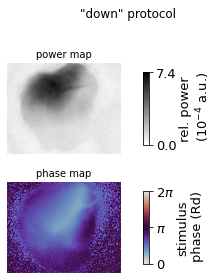

In [67]:
fig = physion.intrinsic.Analysis.plot_phase_power_maps(maps, 'down') # just one stim: "down"

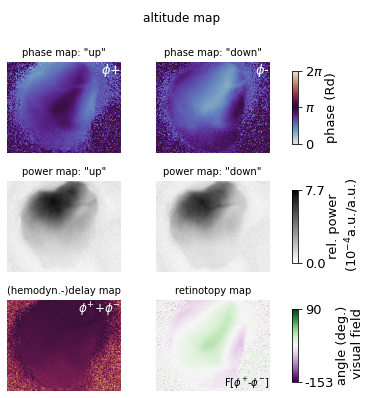

In [65]:
# azimuth = "up" - "down" protocols
fig = physion.intrinsic.Analysis.plot_retinotopic_maps(maps, 'altitude')
fig.suptitle('altitude map');

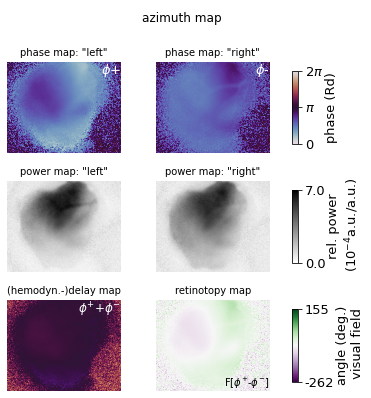

In [66]:
# azimuth = "right" - "left" protocols
fig = physion.intrinsic.Analysis.plot_retinotopic_maps(maps, 'azimuth')
fig.suptitle('azimuth map');

# Visual Area segmentation

Copied from:
    
https://nbviewer.org/github/zhuangjun1981/retinotopic_mapping/blob/master/retinotopic_mapping/examples/signmap_analysis/retinotopic_mapping_example.ipynb
    
    
/!\ Cite the original implementation/work by Jun Zhuang: *Zhuang et al., Elife 2017*

https://elifesciences.org/articles/18372


In [3]:
# --- load standard modules
import pprint, os, sys
import numpy as np
import matplotlib.pylab as plt

# --- physion modules
sys.path.append(os.path.join(os.path.expanduser('~'), 'work', 'physion'))
import physion
from physion.dataviz.datavyz.datavyz import graph_env
ge = graph_env('manuscript')

import physion.intrinsic.RetinotopicMapping as rm

pygame 2.1.2 (SDL 2.0.16, Python 3.7.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Segmentation parameters  

#### */!\* REPRODUCED FROM THE ZHUANG J. NOTEBOOK */!\*

- **phaseMapFilterSigma**: The sigma value (in pixels) of Gaussian filter for altitude and azimuth maps. 
    - FLOAT, default = 1.0, recommended range: [0.0, 2.0]. 
    - Large "phaseMapFilterSigma" gives you more patches. Small "phaseMapFilterSigma" gives you less patches.


- **signMapFilterSigma**: The sigma value (in pixels) of Gaussian filter for visual sign maps. 
    - FLOAT, default = 9.0, recommended range: [0.6, 10.0]. 
    - Large "signMapFilterSigma" gives you less patches. Small "signMapFilterSigma" gives you more patches.


- **signMapThr**: Threshold to binarize visual signmap. 
    - FLOAT, default = 0.35, recommended range: [0.2, 0.5], allowed range: [0, 1). 
    - Large signMapThr gives you fewer patches. Smaller signMapThr gives you more patches.


- **closeIter**: Binary close iteration for each raw patches. 
    - INT, default = 3. You do not want to change this parameter very often.


- **openIter**: Binary open iteration for each raw patches. 
    - INT, default = 3. You do not want to change this parameter very often


- **dilationIter**: Binary dilation iteration for each raw patches. 
    - INT, default = 15. You do not want to change this parameter very often. 


- **borderWidth**: Pixel number between adjcent patches. 
    - INT, default = 1. You do not want to change this parameter very often.


- **smallPatchThr**: The patches with pixel number below smallPatchThr will be discarded. 
    - INT, default = 100. You do not want to change this parameter very often.


- **eccMapFilterSigma**: The sigma value of Gaussian filter for eccentricity maps. 
    - FLOAT, default = 10.0. You do not want to change this parameter very often.


- **visualSpacePixelSize**: The pixel size for patch to visual space mapping. 
    - FLOAT, default = 0.5. You do not want to change this parameter very often. 


- **visualSpaceCloseIter**: The binary iteration for visual space coverage for each patch. 
    - INT, default = 15. You do not want to change this parameter very often.


- **splitLocalMinCutStep**: The step width for detecting number of local minimums during spliting. The local minimums detected will be used as marker in the following open cv watershed segmentation. 
    - FLOAT, default = 5.0, recommend range: [0.5, 15.0]. 
    - Small "splitLocalMinCutStep" will make it more likely to split but into less sub patches. Large "splitLocalMinCutStep" will make it less likely to split but into more sub patches. 


- **splitOverlapThr**: Patches with overlap ration larger than this value will go through the split procedure. 
    - FLOAT, default = 1.1, recommend range: [1.0, 1.2], should be larger than 1.0. 
    - Small "splitOverlapThr" will split more patches. Large "splitOverlapThr" will split less patches. 


- **mergeOverlapThr**: Considering a patch pair (A and B) with same sign, A has visual coverage a deg<sup>2</sup> and B has visual coverage b deg<sup>2</sup> and the overlaping visual coverage between this pair is c deg<sup>2</sup>. Then if (c/a < "mergeOverlapThr") and (c/b < "mergeOverlapThr"), these two patches will be merged. 
    - FLOAT, default = 0.1, recommend range: [0.0, 0.2], should be smaller than 1.0. 
    - Small "mergeOverlapThr" will merge less patches. Large "mergeOverlapThr" will merge more patches.

In [7]:
# to update parameters
params = {'phaseMapFilterSigma': 1.,
          'signMapFilterSigma': 9.,
          'signMapThr': 0.35,
          'eccMapFilterSigma': 10.0,
          'splitLocalMinCutStep': 5.,
          'closeIter': 3,
          'openIter': 3,
          'dilationIter': 15,
          'borderWidth': 1,
          'smallPatchThr': 100,
          'visualSpacePixelSize': 1,
          'visualSpaceCloseIter': 15,
          'splitOverlapThr': 1.1,
          'mergeOverlapThr': 0.0}

datafolder = os.path.join(os.path.expanduser('~'), 'DATA', '2022_09_13', '15-26-26')
# -- loading data
maps = physion.intrinsic.Analysis.load_maps(datafolder)

trial_data = physion.intrinsic.Analysis.build_trial_data(maps, with_params=False)
trial = rm.RetinotopicMappingTrial(**trial_data, params=params)

## Run the segmentation procedure

### Generating visual sign map

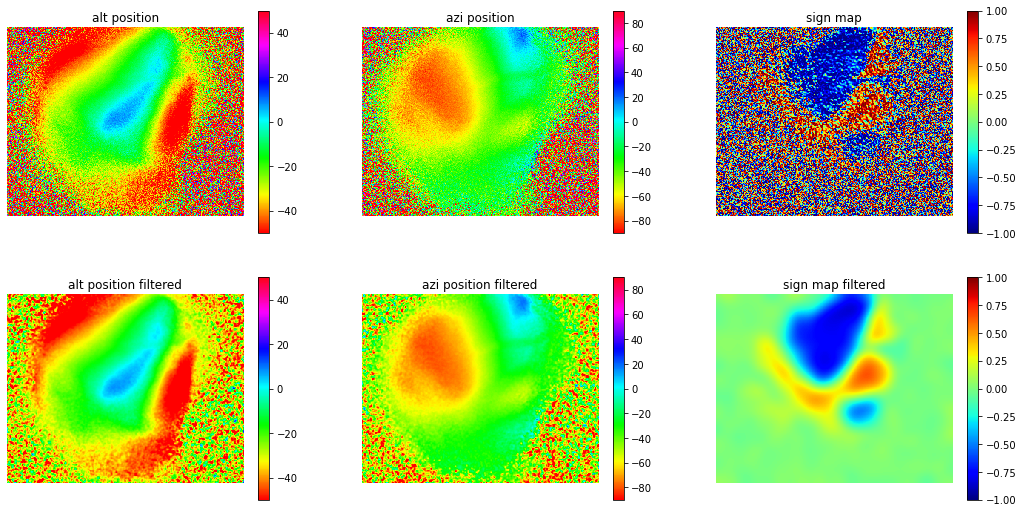

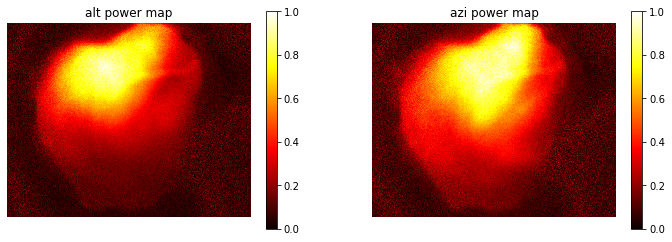

In [8]:
_ = trial._getSignMap(isPlot=True)

### Binarizing filtered visual signmap

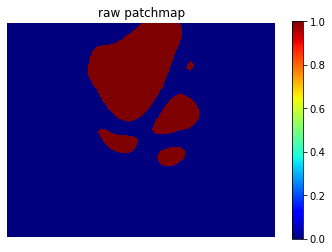

In [9]:
_ = trial._getRawPatchMap(isPlot=True)

### Generating raw patches

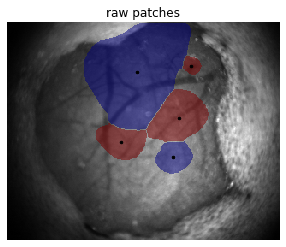

In [10]:
plt.close('all')
_ = trial._getRawPatches(isPlot=True)

### Generating determinant map

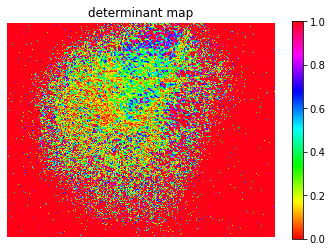

In [11]:
_ = trial._getDeterminantMap(isPlot=True)

### Generating eccentricity map for each patch

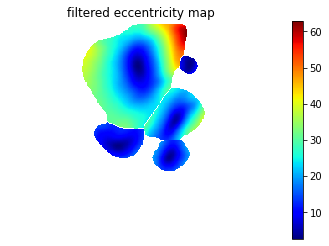

In [12]:
_ = trial._getEccentricityMap(isPlot=True)

patch01AU=3338.0 AS=4575.212306717333 ratio=1.3706447893101659
Only one local minumum was found!!!
patch02AU=1263.0 AS=2106.6329793452564 ratio=1.6679596035987778
Only one local minumum was found!!!
patch03AU=566.0 AS=650.9929677706308 ratio=1.1501642540117152
Only one local minumum was found!!!
patch04AU=508.0 AS=1043.9016020119186 ratio=2.0549244134092888
Only one local minumum was found!!!
patch05AU=190.0 AS=208.88114975553 ratio=1.0993744723975263


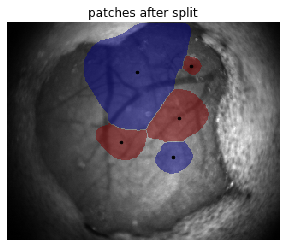

In [13]:
_ = trial._splitPatches(isPlot=True)

merge iteration: 1


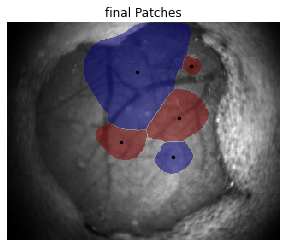

In [14]:
_ = trial._mergePatches(isPlot=True)

In [16]:
_ = trial._getRawPatches()

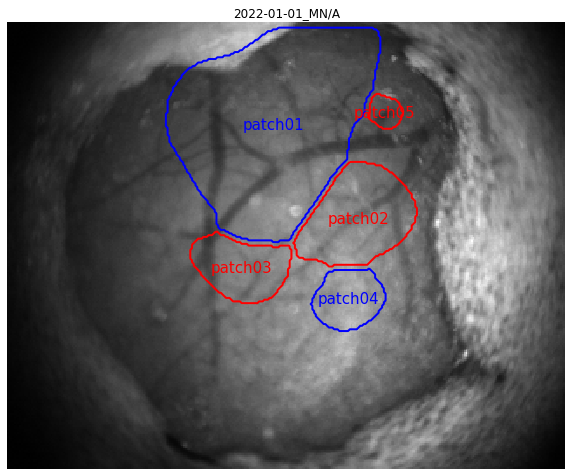

In [17]:
_ = trial.plotFinalPatchBorders2()

In [22]:
names = [
         ['patch01', 'V1'],
         ['patch02', 'PM'],
         ['patch03', 'RL'],
         ['patch04', 'AM'],
         ['patch05', ''],
         ]

finalPatchesMarked = dict(trial.finalPatches)

for i, namePair in enumerate(names):
    currPatch = finalPatchesMarked.pop(namePair[0])
    newPatchDict = {namePair[1]:currPatch}
    finalPatchesMarked.update(newPatchDict)
    
trial.finalPatchesMarked = finalPatchesMarked

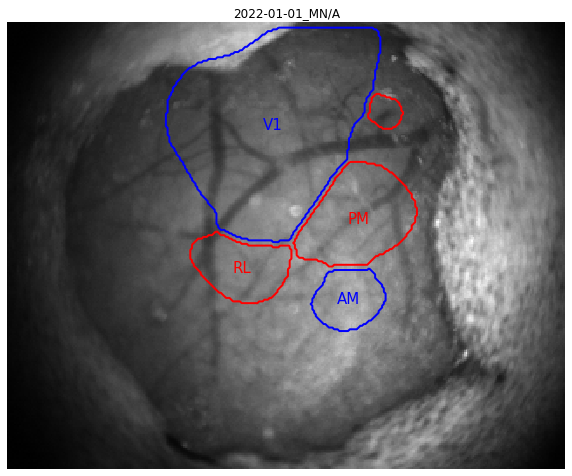

In [23]:
_ = trial.plotFinalPatchBorders2()
#plt.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig.svg'))

# Demo of FFT analysis of periodic stimulation
Strategy of Kalatsky & Stryker, _Neuron_ (2003). See: http://doi.org/10.1016/s0896-6273(03)00286-1

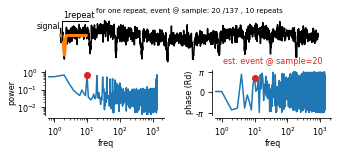

In [14]:
# demo of analysis motivation
import numpy as np

max_sample = 20

def from_angle_to_fraction(angle):
    return -(angle-np.pi)/2./np.pi
    
def demo_fig(max_sample,
             nrepeat=10,
             n_sample_per_repeat= 137,
             signal_amplitude=0.8,
             noise_fraction=0.2,
             slow_fraction=0.2,
             seed=10):
    
    np.random.seed(seed)
    fig, AX = ge.figure(axes_extents=[[[2,1]],[[1,1],[1,1]]], figsize=(1.4,1), wspace=0.7, hspace=0.2)
    
    x = -np.exp(-(np.arange(n_sample_per_repeat)-max_sample)**2/30)+3500
    X = np.concatenate([x for n in range(nrepeat)])
    X += noise_fraction*np.random.randn(len(X))+slow_fraction*np.sin(np.linspace(0, 10, len(X)))
    
    AX[0][0].plot(X, 'k-')
    AX[0][0].plot(x, lw=3, color=ge.orange)
    ge.draw_bar_scales(AX[0][0], Xbar=n_sample_per_repeat, Xbar_label='1repeat',
                       Ybar=1, Ybar_label='signal', remove_axis=True)
    ge.title(AX[0][0], 'for one repeat, event @ sample: %i /%i , %i repeats' % (max_sample, n_sample_per_repeat, nrepeat), size='small')
    spectrum = np.fft.fft(X)
    power, phase = np.abs(spectrum)/len(x), np.angle(spectrum)
    AX[1][0].plot(power)
    AX[1][0].plot([nrepeat], [power[nrepeat]], 'o', color=ge.red)
    AX[1][1].plot(phase)
    AX[1][1].plot([nrepeat], [phase[nrepeat]], 'o', color=ge.red)
    ge.title(AX[1][1], 'est. event @ sample=%i' % (from_angle_to_fraction(phase[nrepeat])*n_sample_per_repeat), color=ge.red)
    ge.set_plot(AX[1][0], xscale='log', yscale='log', ylim=[power.min(), 2*power[nrepeat]],
                xlabel='freq', ylabel='power')
    ge.set_plot(AX[1][1], xscale='log', xlabel='freq', ylabel='phase (Rd)', yticks=[-np.pi, 0, np.pi],
               yticks_labels=['-$\pi$', '0', '$\pi$'])
    return fig

demo_fig(20, seed=3);

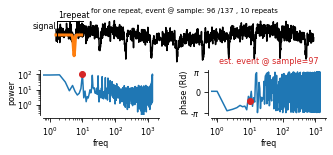

In [8]:
demo_fig(96);

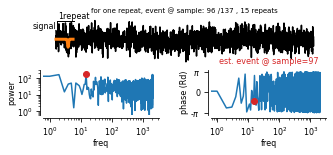

In [9]:
ge.save_on_desktop(demo_fig(96, noise_fraction=0.8, nrepeat=15), 'fig.png')